# Problem

The dental office Mitch Smile have a percetange of the final due that isn't paid by the insurance carriers through the claim. This pending due must be covered by the patient. 

# Objective
Design a deep learning model to predict the amount will be paid by the insurance carrier through the claim

# Imports 

In [96]:
import pandas as pd #import pandas
import numpy as np #import numpy
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer


# Dataset pre process 
take data sources input (claim & income) to create a single dataset

In [332]:
####income table process####
current_dir = os.getcwd().replace('\\', '/')
income_table=f"{current_dir}/income_table.xlsx"#xlsx path

income_table_df=pd.read_excel(open(income_table, 'rb'),#openfile
              sheet_name='income')  
#get unique value in column 
print(income_table_df.iloc[:,6].unique())
#filter dataframe by unique value
income_table_df=income_table_df[(income_table_df.iloc[:,6]!='Cash') & (income_table_df.iloc[:,6]!='Visa') & (income_table_df.iloc[:,6]!='Master Card') & (income_table_df.iloc[:,6]!='American Express') & (income_table_df.iloc[:,6]!='Discover') & (income_table_df.iloc[:,6]!='Other')]
#income_table_df=income_table_df[income_table_df.iloc[:,6]!='American Express'& income_table_df.iloc[:,6]!='Discover']
print(income_table_df.iloc[:,6].unique())
print(income_table_df['prompt'].unique())
income_table_df=income_table_df[income_table_df['prompt']!=None]

#convert string to datetime
income_table_df['tran_date']=pd.to_datetime(income_table_df['tran_date'])
#only 2021
target_year=datetime.now().year - 2
income_table_df=income_table_df[income_table_df['tran_date'].dt.year==target_year]
income_table_df=income_table_df.sort_values(by=['tran_date'])

#split string in two columns
income_table_df['claim_date']=income_table_df['description.1'].str.split('for claim from',expand=True)[1]
income_table_df['claim_date']=income_table_df['claim_date'].str.strip()
#filter claim_date column by description.1 value
#not contain 'for claim from'
issue_table_df=income_table_df[income_table_df['description.1'].str.contains('for claim from')==False]

#save issue table as xlsx 
issue_table_df.to_excel(f'{current_dir}/issue_table.xlsx')
#convert string to datetime with format
#function for multiple format
def convert_date(x):
      try:
          return pd.to_datetime(x, format='%m/%d/%y')
      except ValueError:
          return pd.to_datetime(x, format='%m/%d/%Y')


income_table_df['claim_date']=income_table_df['claim_date'].apply(convert_date)
income_table_df['claim_number']=income_table_df['description.1'].str.split('for claim from',expand=True)[0]
#print(income_table_df)
#group
#income_table_df['income_date']=pd.to_datetime(income_table_df['tran_date'])#,format='%m/%d/%Y')
income_table_df['income_date']=income_table_df['tran_date']
#change sign to amount
income_table_df['amount']=income_table_df['amount']*-1
income_table_df['amount.1']=income_table_df['amount.1']*-1

#income_table_df['amount']=income_table_df.groupby(by=['patient_id','tran_num','tran_date','income_date'])['amount'].transform(lambda x: x.sum())
#income_table_df=income_table_df.drop_duplicates(subset=['patient_id','tran_num','tran_date','amount','income_date'], keep='first')
income_table_df['amount']=income_table_df.groupby(by=['patient_id','tran_date','claim_date'])['amount'].transform(lambda x: x.sum())
income_table_df=income_table_df.drop_duplicates(subset=['patient_id','tran_date','amount','claim_date'], keep='first')
filtered_income=income_table_df[['patient_id','claim_date','amount','income_date','claim_number']]
#save as xlsx
#income_table_df.to_excel('{current_dir}/income_table_new.xlsx')


####claim history table process####you

claim_table=f"{current_dir}/claim_history.xlsx"#xlsx path

claim_table_df=pd.read_excel(open(claim_table, 'rb'),#openfile
              sheet_name='claim')  

#strip spaces
claim_table_df['insurance_company_name']=claim_table_df['insurance_company_name'].str.strip()#.str.upper().str.replace('*', '').str.replace('(', '').str('').str.replace(')', '').str.replace('-', '').str.replace('/', '').str.replace('\\', '').str.replace('.', '').str.replace(' ', '')
#clean special characters except for ' '
claim_table_df['insurance_company_name']=claim_table_df['insurance_company_name'].str.replace('[^A-Za-z0-9\s]+', '')
#title case
claim_table_df['insurance_company_name']=claim_table_df['insurance_company_name'].str.title()
#replace string
claim_table_df['insurance_company_name']=claim_table_df['insurance_company_name'].str.replace('Ppo', '').replace('Global','')
#strip spaces
claim_table_df['insurance_company_name']=claim_table_df['insurance_company_name'].str.strip()
print(claim_table_df['insurance_company_name'].unique())
#fill nan valuea
claim_table_df['prim_or_sec']=claim_table_df['prim_or_sec'].fillna('P')
#convert string to datetime
claim_table_df['tran_date']=pd.to_datetime(claim_table_df['tran_date'])#,format='%m/%d/%Y')#fecha del claim
#create new columns income date
#claim_table_df['income_date']=claim_table_df['tran_date']
#only current year
target_year=datetime.now().year - 2
claim_table_df=claim_table_df[claim_table_df['tran_date'].dt.year==target_year]
claim_table_df=claim_table_df.sort_values(by=['tran_date'])
#
claim_table_df['claim_date']=claim_table_df['tran_date']
print(claim_table_df['claim_date'])
#combine rows
claim_table_df['fee']=claim_table_df['fee'].fillna(0)
claim_table_df['fee']=claim_table_df.groupby(by=['patient_id','statement_num','tran_date'])['fee'].transform(lambda x: x.sum())

claim_table_df['est_primary']=claim_table_df['est_primary'].fillna(0)
#claim_table_df['est_primary']=claim_table_df.groupby(by=['patient_id','statement_num','tran_date'])['est_primary'].transform(lambda x: x.sum())

#claim_table_df['service_code']=claim_table_df.groupby(by=['patient_id','statement_num','tran_date'])['service_code'].transform(lambda x: ','.join(x))
#claim_table_df['description']=claim_table_df.groupby(by=['patient_id','statement_num','tran_date'])['description'].transform(lambda x: ','.join(x))
#drop duplicates
#claim_table_df=claim_table_df.drop_duplicates(subset=['patient_id','statement_num','tran_date','service_code','description'], keep='first')
claim_table_df['est_primary']=claim_table_df.groupby(by=['patient_id','tran_date'])['est_primary'].transform(lambda x: x.sum())

claim_table_df['service_code']=claim_table_df.groupby(by=['patient_id','tran_date'])['service_code'].transform(lambda x: ','.join(x))
claim_table_df['description']=claim_table_df.groupby(by=['patient_id','tran_date'])['description'].transform(lambda x: ','.join(x))
#drop duplicates
claim_table_df=claim_table_df.drop_duplicates(subset=['patient_id','tran_date','service_code','description'], keep='first')

#substract two values
claim_table_df['cash_payment']=claim_table_df['fee']-claim_table_df['est_primary']
#percentage of payment
claim_table_df['coverage_expected']=claim_table_df['est_primary']/claim_table_df['fee']*100

print(claim_table_df.head())
####merge income and claim history table####
#save as xlsx
#claim_table_df.to_excel('C:/PIA/final/claim_history_new.xlsx')
#left join claim_history and income_table
merged_table_df=pd.merge(claim_table_df,filtered_income,on=['patient_id','claim_date'],how='left')
#fill nan values of amount
merged_table_df['amount']=merged_table_df['amount'].fillna(0)
#fill nan values of income date with claim date
merged_table_df['income_date']=merged_table_df['income_date'].fillna(merged_table_df['claim_date'])

#substract dates to get days
merged_table_df['days_of_waiting']=(merged_table_df['income_date']-merged_table_df['claim_date']).dt.days
#real coverage
#merged_table_df['real_coverage']=merged_table_df['amount']/merged_table_df['fee']*100
#write off
#merged_table_df['write_off']=merged_table_df['est_primary']-merged_table_df['amount']
#percentage of write off
#merged_table_df['percentage_write_off']=(1-merged_table_df['amount']/merged_table_df['est_primary'])*100
merged_table_df['service_code_list']=merged_table_df['service_code'].str.split(',')
merged_table_df['service_code'] = merged_table_df['service_code_list']
merged_table_df.drop('service_code_list', axis=1, inplace=True, index=None)
data=merged_table_df
data["target"] = data["amount"]
data.drop("amount", axis=1, inplace=True)
data = data.dropna(subset=['coverage_expected'])
data = data.reset_index(drop=True)


['Cash' 'Check' 'Insurance Check' 'Care Credit' 'Visa' 'Master Card'
 'American Express' 'Discover' 'VCC' 'INS CREDIT CARD']
['Check' 'Insurance Check' 'Care Credit' 'VCC' 'INS CREDIT CARD']
['Number' nan 'NUMBER']
['Aetna Dental' 'Aetna Dental*' 'Aetna Vital Savings (Disscount Plan)'
 'Aetna Voluntary' 'Aliera Healthcare Trinity' 'Allianz Worldwide Care'
 'Ameritas' 'Ameritas- Reliance Standard' 'Anthem'
 'Anthem Dental Services' 'Associated Administrators, Llc' 'Assurant'
 'Avmed' 'Bcbs Global' 'Bcbs North Carolina' 'Beam'
 'Blue Cross Blue Shiedl Fep Dental' 'Blue Cross Blue Shield'
 'Blue Cross Blue Shield Of Alabama' 'Blue Cross Blue Shield Of Illinois'
 'Blue Cross Blue Shield Of Massachusetts'
 'Blue Cross Blue Shield Of Michigan' 'Blue Cross Blue Shield Of Texas'
 'Blue Cross Blue Shield Pennsylvania'
 'Blue Cross Blue Shiled Of Tennessee'
 'Blue Cross Of Washington (Premera)' 'Blue Dental Choice'
 'Blue Shiled Of California' 'Bluecross Blueshield Global'
 'Care First Dental' '

#  Data Analysis

In [333]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438 entries, 0 to 5437
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   patient_id              5438 non-null   int64         
 1   statement_num           5438 non-null   int64         
 2   provider_id             5438 non-null   object        
 3   service_code            5438 non-null   object        
 4   description             5438 non-null   object        
 5   tooth                   1189 non-null   object        
 6   surface                 344 non-null    object        
 7   fee                     5438 non-null   float64       
 8   tran_num                5438 non-null   int64         
 9   responsible_party       5438 non-null   int64         
 10  prim_employer_id        5411 non-null   float64       
 11  est_primary             5438 non-null   float64       
 12  est_secondary           5438 non-null   float64 

In [315]:
data.head(10)

,patient_id,statement_num,provider_id,service_code,description,tooth,surface,fee,tran_num,responsible_party,...,claim_type,insurance_company_name,prim_or_sec,claim_date,cash_payment,coverage_expected,income_date,claim_number,days_of_waiting,target
0,9622,140464,P2,"[D9230, D2393, D3120]","Nitrous Oxide /ANALGESIA,RESIN-BASED COMPOSITE...",NaN,NaN,533.0,360139,9621,...,C,Delta Dental Of Massachusetts,P,2021-01-04,266.6,49.981238,2021-03-11,26295453,66,266.4
1,17859,140467,P2,"[D0220, D1206, D1120, D0120]","INTRAORAL-PERIAPICAL FIRST FILM,TOP FLUOR VARN...",E,NaN,139.0,360148,16947,...,C,United Healthcare,P,2021-01-04,0.0,100.000000,2021-01-22,0011728121,18,139.0
2,17850,140463,P2,"[D0120, D1120, D1206, D0220]","PERIODIC ORAL EVALUATION,PROPHYLAXIS-CHILD,TOP...",NaN,NaN,146.0,360134,17849,...,C,Cigna,P,2021-01-04,0.0,100.000000,2021-03-09,55030230,64,146.0
3,879,140476,P2,"[D0120, D1110, D0220, D0230]","PERIODIC ORAL EVALUATION,PROPHYLAXIS-ADULT,INT...",NaN,NaN,155.0,360176,878,...,C,Cigna,P,2021-01-04,0.0,100.000000,2021-11-18,306492199,318,119.0
4,4821,140489,P2,"[D1206, D0272, D0120, D1120, D2391]","TOP FLUOR VARNISH; APPL MOD/HIGH RISK,BITEWING...",NaN,NaN,298.0,360222,4820,...,C,Humana,P,2021-01-04,57.8,80.604027,2021-03-11,2834,66,170.0
5,6966,140480,P2,"[D1206, D1120, D0120]","TOP FLUOR VARNISH; APPL MOD/HIGH RISK,PROPHYLA...",NaN,NaN,226.0,360200,6965,...,C,Delta Dental Insurance Company,P,2021-01-04,65.0,71.238938,2021-01-22,0052245873,18,151.0
6,6788,140484,P2,"[D0220, D2391]","INTRAORAL-PERIAPICAL FIRST FILM,RESIN-BASED CO...",8,NaN,133.0,360204,6787,...,C,Metlife,P,2021-01-04,89.2,32.932331,2021-05-06,548125744,122,43.8
7,12325,140478,P2,"[D1351, D1351, D1351, D1351]","SEALANT-PER TOOTH MOLAR,SEALANT-PER TOOTH MOLA...",30,NaN,208.0,360184,12324,...,C,Delta Dental Of California*,P,2021-01-04,0.0,100.000000,2021-01-22,0061161130,18,208.0
8,14620,140478,P2,"[D1206, D0220, D0272, D0120, D1120]","TOP FLUOR VARNISH; APPL MOD/HIGH RISK,INTRAORA...",NaN,NaN,322.0,360188,12324,...,C,Delta Dental Of California*,P,2021-01-04,0.0,100.000000,2021-01-22,0061161130,18,292.0
9,5140,140491,P2,"[D0120, D1110, D1206, D0272]","PERIODIC ORAL EVALUATION,PROPHYLAXIS-ADULT,TOP...",NaN,NaN,178.0,360229,5139,...,C,Cigna,P,2021-01-04,0.0,100.000000,2021-01-28,95379845,24,158.0


In [317]:
data.isna().sum()

patient_id                   0
statement_num                0
provider_id                  0
service_code                 0
description                  0
tooth                     4249
surface                   5094
fee                          0
tran_num                     0
responsible_party            0
prim_employer_id            27
est_primary                  0
est_secondary                0
tran_date                    0
type                         0
claim_type                   0
insurance_company_name       0
prim_or_sec                  0
claim_date                   0
cash_payment                 0
coverage_expected            0
income_date                  0
claim_number              1199
days_of_waiting              0
target                       0
dtype: int64

In [334]:
#Drop columnns
df = data.drop(columns=["description","tooth","surface","prim_employer_id","patient_id","statement_num","provider_id","tran_num","tran_date","responsible_party","income_date","claim_number","days_of_waiting","type","claim_type","claim_date"])
df.head()

,service_code,fee,est_primary,est_secondary,insurance_company_name,prim_or_sec,cash_payment,coverage_expected,target
0,"[D9230, D2393, D3120]",533.0,266.4,0.0,Delta Dental Of Massachusetts,P,266.6,49.981238,266.4
1,"[D0220, D1206, D1120, D0120]",139.0,139.0,0.0,United Healthcare,P,0.0,100.000000,139.0
2,"[D0120, D1120, D1206, D0220]",146.0,146.0,0.0,Cigna,P,0.0,100.000000,146.0
3,"[D0120, D1110, D0220, D0230]",155.0,155.0,0.0,Cigna,P,0.0,100.000000,119.0
4,"[D1206, D0272, D0120, D1120, D2391]",298.0,240.2,0.0,Humana,P,57.8,80.604027,170.0


In [335]:
df.isna().sum()

service_code              0
fee                       0
est_primary               0
est_secondary             0
insurance_company_name    0
prim_or_sec               0
cash_payment              0
coverage_expected         0
target                    0
dtype: int64

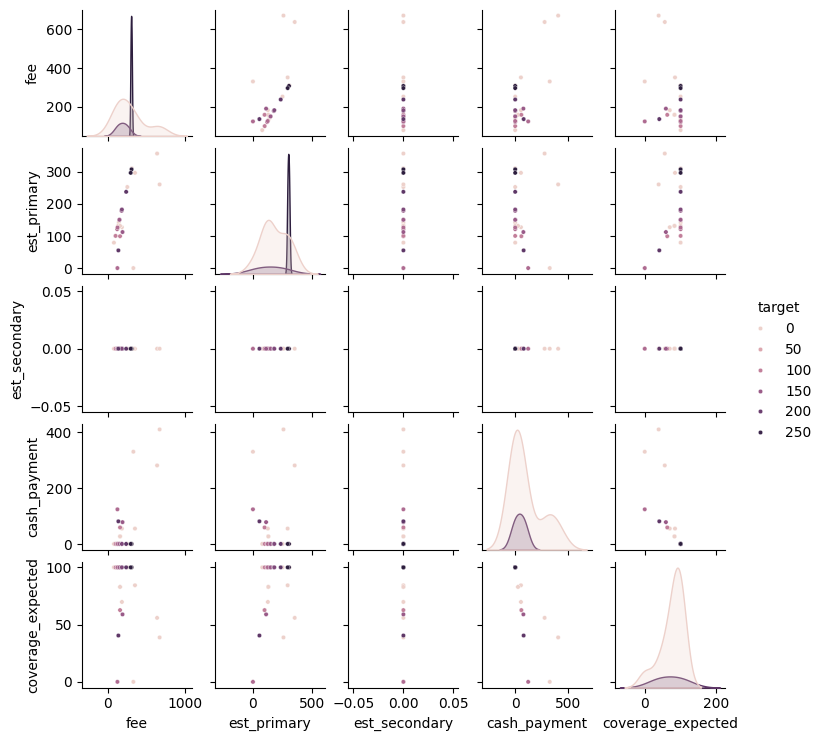

In [344]:
Num_feats = df.select_dtypes("float64").copy()
sample_for_pair_plot = Num_feats.groupby("target", group_keys=False).apply(
    lambda x: x.sample(frac=0.01)
)

sns.pairplot(
    sample_for_pair_plot,
    hue="target",
    kind="scatter",
    diag_kind="kde",
    height=1.5,
    aspect=1,
    plot_kws=dict(s=10),
)
plt.show()

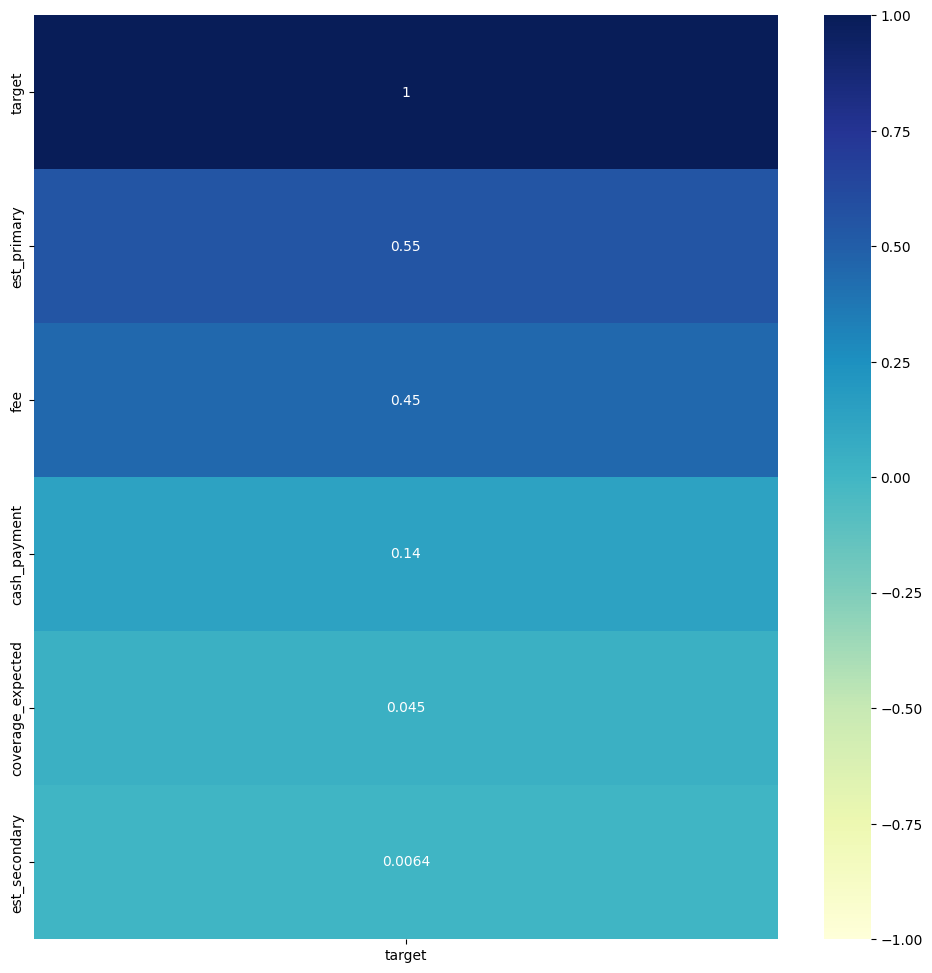

In [205]:
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(Num_feats.corr()[['target']].sort_values('target').tail(11),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax)

ax.invert_yaxis()

In [350]:
#Hot encoding
mlb = MultiLabelBinarizer(sparse_output=True)
#services
df_backup = df.copy()
df_labeled = df_backup.join(
              pd.DataFrame.sparse.from_spmatrix(
                  mlb.fit_transform(df_backup.pop('service_code')),
                  index=data.index,
                  columns=mlb.classes_))

In [351]:
#hot encoding for insurance type
df_labeled["prim_or_sec"] = df_labeled["prim_or_sec"].astype('category')
df_col = df_labeled["prim_or_sec"]
encoded_ins = pd.get_dummies(df_col, columns=['prim_or_sec'], prefix='ins_type')
encoded_ins = encoded_ins.astype(int)
for col in encoded_ins.columns:
    df_labeled[col] = encoded_ins[col]
df_labeled.drop('prim_or_sec', axis=1, inplace=True)
#hot enconding for insurance company
# Convert the 'Category' column to a categorical type
df_labeled['insurance_company_name'] = df_labeled['insurance_company_name'].astype('category')
df_col = df_labeled["insurance_company_name"]
# # Perform one-hot encoding using pd.get_dummies()
encoded_ins = pd.get_dummies(df_col, columns=['insurance_company_name'], prefix='Insurance')
encoded_ins = encoded_ins.astype(int)
for col in encoded_ins.columns:
    df_labeled[col] = encoded_ins[col]
df_labeled.drop('insurance_company_name', axis=1, inplace=True)


In [343]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438 entries, 0 to 5437
Columns: 162 entries, fee to Insurance_Unum
dtypes: Sparse[int32, 0](67), float64(6), int32(89)
memory usage: 2.2 MB


In [352]:
# Define standard scaler
scaler = StandardScaler()

# Transform data
scaled = scaler.fit_transform(Num_feats)

# # Convert numpy array to pandas dataframe
Num_feats_scaled = pd.DataFrame(scaled, columns = Num_feats.columns)

df_scaled = df_labeled.copy()
for col in Num_feats_scaled.columns:
     df_scaled[col] = Num_feats_scaled[col]


In [353]:
Num_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438 entries, 0 to 5437
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fee                5438 non-null   float64
 1   est_primary        5438 non-null   float64
 2   est_secondary      5438 non-null   float64
 3   cash_payment       5438 non-null   float64
 4   coverage_expected  5438 non-null   float64
 5   target             5438 non-null   float64
dtypes: float64(6)
memory usage: 255.0 KB


In [385]:
# X = df_scaled.iloc[:,:-1] 
# y = df_scaled.iloc[:,-1]
X = Num_feats_scaled.iloc[:,:-1] 
y = Num_feats_scaled.iloc[:,-1]
# Split samples between train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

In [432]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='tanh',kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 32)                192       
                                                                 
 dense_111 (Dense)           (None, 8)                 264       
                                                                 
 dense_112 (Dense)           (None, 16)                144       
                                                                 
 dense_113 (Dense)           (None, 1)                 17        
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________


In [433]:
model.compile(optimizer = 'adam', loss = 'mse')

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(X_train, y_train, validation_split = 0.2,
                    batch_size = 100, epochs = 400,
                    callbacks = [early_stop])

Epoch 1/400
30/30 [==============================] - 1s 8ms/step - loss: 1.0483 - val_loss: 0.8976
Epoch 2/400
30/30 [==============================] - 0s 4ms/step - loss: 0.8849 - val_loss: 0.8234
Epoch 3/400
30/30 [==============================] - 0s 4ms/step - loss: 0.8034 - val_loss: 0.7743
Epoch 4/400
30/30 [==============================] - 0s 5ms/step - loss: 0.7577 - val_loss: 0.7530
Epoch 5/400
30/30 [==============================] - 0s 4ms/step - loss: 0.7365 - val_loss: 0.7454
Epoch 6/400
30/30 [==============================] - 0s 4ms/step - loss: 0.7240 - val_loss: 0.7325
Epoch 7/400
30/30 [==============================] - 0s 4ms/step - loss: 0.7124 - val_loss: 0.7253
Epoch 8/400
30/30 [==============================] - 0s 4ms/step - loss: 0.7052 - val_loss: 0.7151
Epoch 9/400
30/30 [==============================] - 0s 4ms/step - loss: 0.6969 - val_loss: 0.7089
Epoch 10/400
30/30 [==============================] - 0s 5ms/step - loss: 0.6912 - val_loss: 0.7001
Epoch 11/

<Axes: >

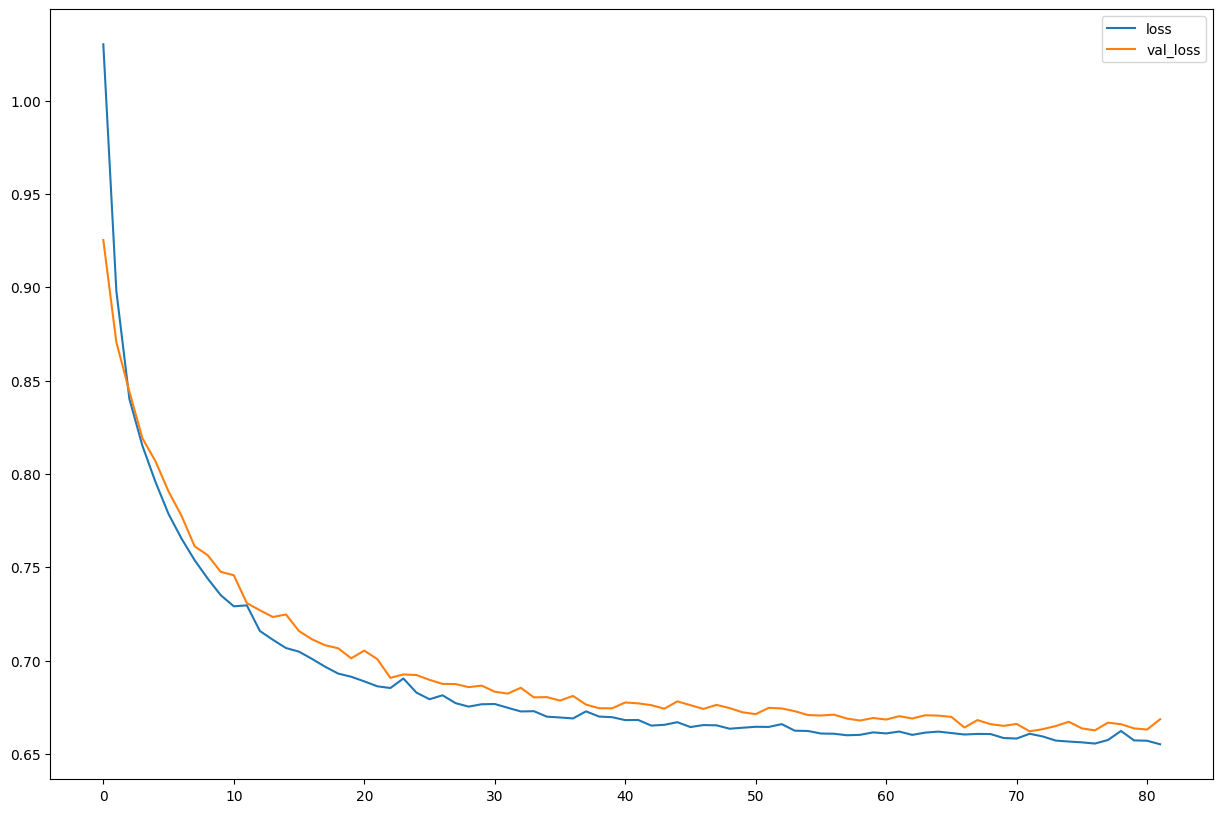

In [424]:
history_df = pd.DataFrame(model.history.history)
history_df.plot(figsize=(15,10))

In [426]:
y_predicted = model.predict(X_test)

print('r2_score: ',r2_score(y_test, y_predicted))

57/57 [==============================] - 0s 2ms/step
r2_score:  0.3576217868603887


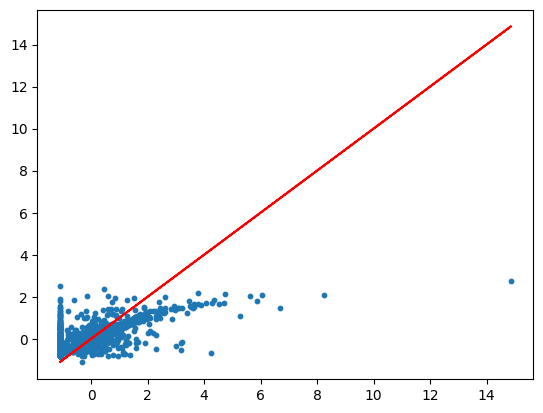

In [428]:
plt.scatter(y_test, y_predicted, s=10)
plt.plot(y_test, y_test, c= 'red')
